In [ ]:
import re
import json
import torch
import zipfile
import sklearn
import logging
import numpy as np
import transformers
import pandas as pd
import seaborn as sns
import itertools
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 150

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import RobertaModel, RobertaTokenizer

logging.basicConfig(level=logging.ERROR)
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import BertTokenizer, TFBertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaTokenizer, RobertaForSequenceClassification,get_linear_schedule_with_warmup

In [ ]:
df = pd.read_csv("train (1).csv",encoding="iso-8859-1")
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [ ]:
len(df)

27481

In [ ]:
def preprocess_text(text):
    regex = r'[^\w\s]|[\U0001f600-\U0001f64f\U0001f300-\U0001f5ff\U0001f680-\U0001f6ff\U0001f1e0-\U0001f1ff]'
    text = re.sub(regex, " ", text)
    text = re.sub("\.|\,|\/|\-", " ", text) 
    text = re.sub("\s*\s", " ", text)
    return text

In [ ]:
for i in range(len(df)):
  df.loc[i,"text"] = preprocess_text(str(df.loc[i,"text"]))

In [ ]:
df["sentiment"] = df["sentiment"].replace({"neutral":0,"positive":1,"negative":2})

In [ ]:
df = df[["text","sentiment"]]

In [ ]:
train_text,test_text,train_labels,test_labels = train_test_split(df["text"],df["sentiment"],test_size=0.4)
val_text,test_text,val_labels,test_labels = train_test_split(test_text,test_labels,test_size=0.4)

In [ ]:
num_classes = 3
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [ ]:
def convert_example_to_feature(review):
    return bert_tokenizer.encode_plus(
        review,
        add_special_tokens=True,  # add [CLS], [SEP]
        max_length=512,  # max length of the text that can go to BERT
        padding='max_length',
        truncation=True,
        return_attention_mask=True,  # add attention mask to not focus on pad tokens
    )


In [ ]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_masks,
    }, label


def encode_examples(ds):
    # Prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []

    for review, label in ds:
        bert_input = convert_example_to_feature(review)
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])

    return tf.data.Dataset.from_tensor_slices(
        (input_ids_list, attention_mask_list, token_type_ids_list, label_list)
    ).map(map_example_to_dict)


In [ ]:
batch_size = 8

In [ ]:
ds_train = zip(train_text, train_labels)
ds_test = zip(test_text, test_labels)
ds_train_encoded = encode_examples(ds_train).shuffle(len(train_text)).batch(batch_size)
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

In [ ]:
model_save_path = 'bert_model.h5'

path = "/content/"

# Initialize pre-built BERT-based classifier from transformers
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=num_classes
)

bert_model.summary()


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Recommended learning rate for Adam: 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

# Multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 4

# Choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    epsilon=1e-08
)

# We do not have one-hot vectors, we can use sparse categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metric
)


In [ ]:
history = bert_model.fit(
    ds_train_encoded,
    batch_size=batch_size,
    epochs=number_of_epochs,
    validation_data=ds_test_encoded,
    verbose=1
)


Epoch 1/4
2061/2061 [==============================] - 2121s 1s/step - loss: 0.6090 - accuracy: 0.7448 - val_loss: 0.5273 - val_accuracy: 0.7860
Epoch 2/4
2061/2061 [==============================] - 2075s 1s/step - loss: 0.4233 - accuracy: 0.8322 - val_loss: 0.5413 - val_accuracy: 0.7831
Epoch 3/4
2061/2061 [==============================] - 2073s 1s/step - loss: 0.2629 - accuracy: 0.9054 - val_loss: 0.6383 - val_accuracy: 0.7794
Epoch 4/4
2061/2061 [==============================] - 2057s 998ms/step - loss: 0.1563 - accuracy: 0.9462 - val_loss: 0.8326 - val_accuracy: 0.7763


In [ ]:
bert_model.save_weights(model_save_path)

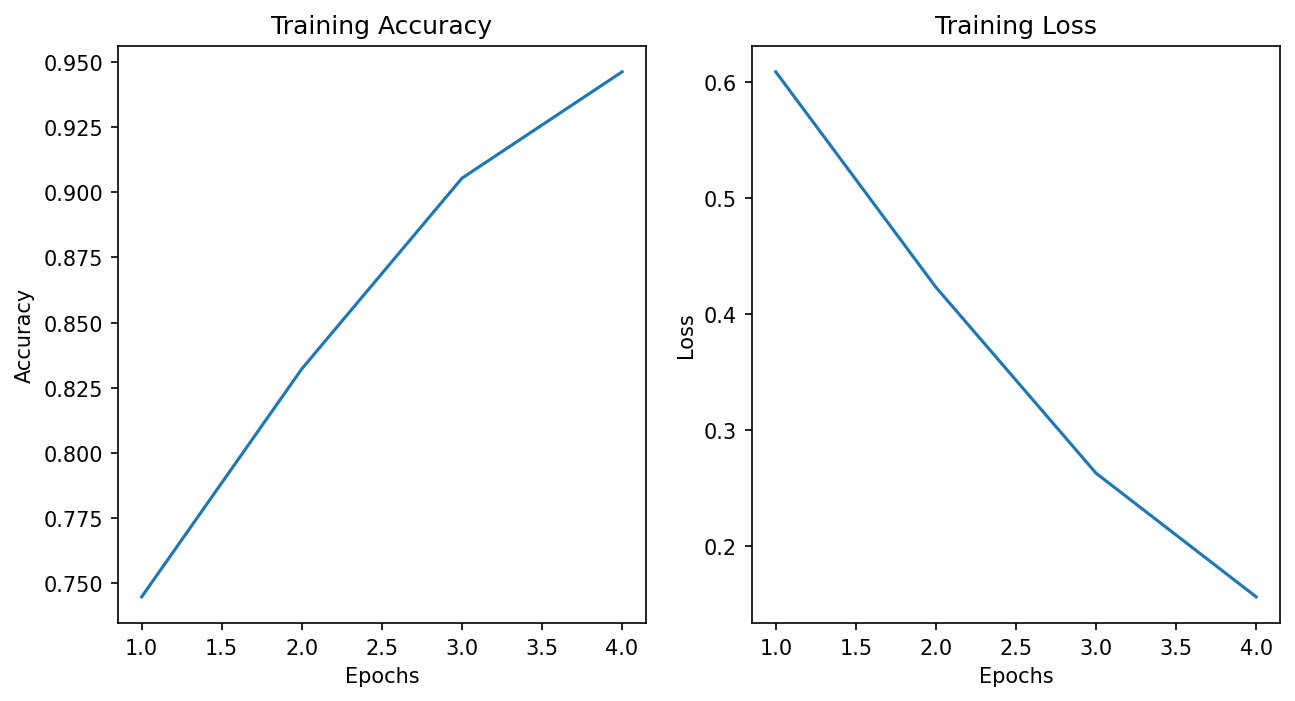

In [ ]:
# Plotting results
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(epochs, acc)
axs[0].set_title("Training Accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")

axs[1].plot(epochs, loss)
axs[1].set_title("Training Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")

plt.show()

In [ ]:
bert_model.evaluate(ds_test_encoded,batch_size=batch_size)

550/550 [==============================] - 185s 336ms/step - loss: 0.8326 - accuracy: 0.7763


[0.8325549960136414, 0.7762619256973267]

In [ ]:
y_test_pred = bert_model.predict(ds_test_encoded,batch_size=batch_size)

550/550 [==============================] - 186s 332ms/step


In [ ]:
y_test_pred_class = y_test_pred[0].argmax(axis=1)

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(target_names, rotation=45)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, "{:0.4f}".format(cm[i, j]) if normalize else "{:,}".format(cm[i, j]),
                horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass))
    plt.show()

In [ ]:
cm = sklearn.metrics.confusion_matrix(test_labels,
                                      y_test_pred_class,
                                      normalize=None)

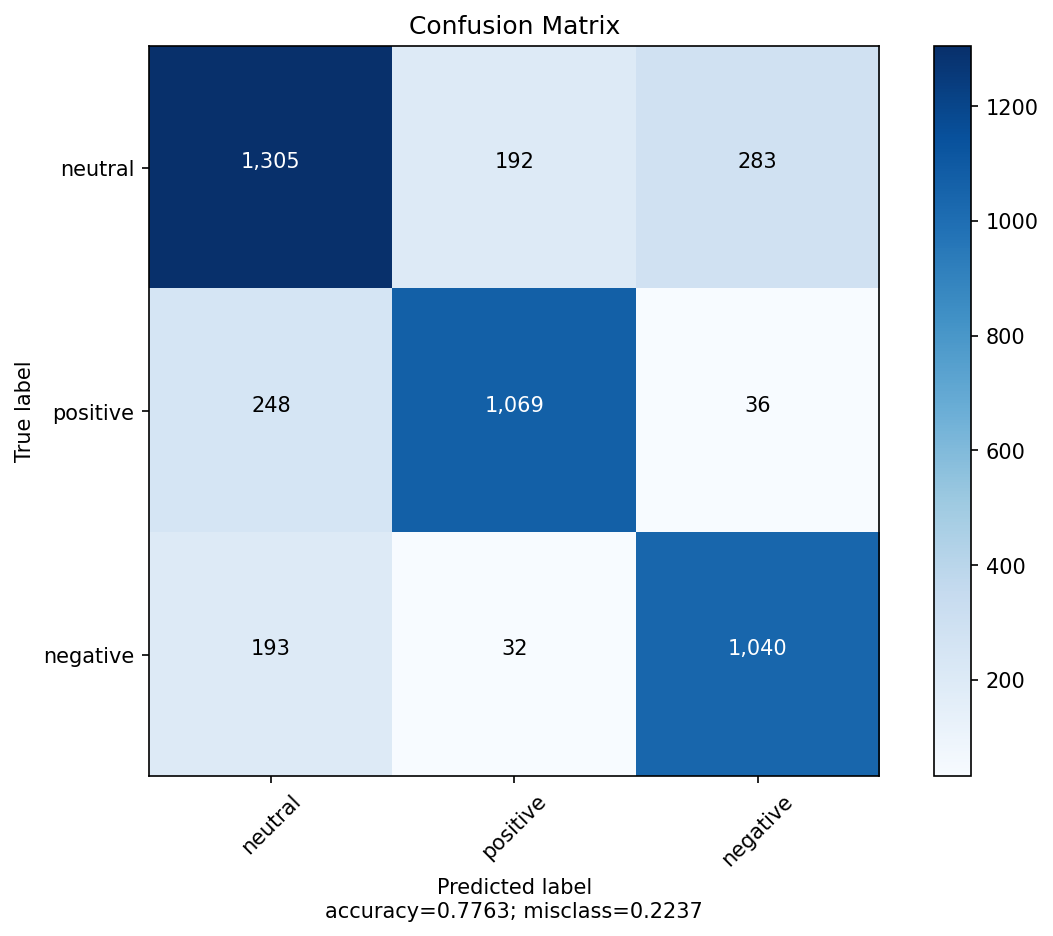

In [ ]:
plot_confusion_matrix(cm,
                      normalize=False,
                      target_names=['neutral', 'positive',"negative"],
                      title="Confusion Matrix")